In [6]:
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [31]:
def getTestFeatures():
    test_data = pd.read_csv("test.csv")
    test_data.F6 = np.log(test_data.F6)
    test_features = test_data.drop(['id'], axis=1)
    return np.array(test_features)

def makeSubmission(preds):
    new_index = np.arange(16384,32769,1)
    id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
    y_hat = pd.DataFrame(preds, columns=['Y'])
    frames = [id_col, y_hat]
    pred = pd.concat(frames, axis=1)
    return pred

# Part 1 Preliminary Inspection
## Feature Engineering
### Load the data and split it
Initial loading of data<br>
Do not overwrite labels and features<br>
```data``` is available as a fresh copy always

In [7]:
filename = 'train.csv'
filepath = ''

data = pd.read_csv(filepath + filename)
#labels = data['Y']
#features = data.drop(['id', 'Y'], axis=1)

### Take a quick look

In [8]:
data.describe()
data.head()
#features.isnull().sum()
#print(features['F25'])
#features.dtypes

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,0.0,0.0,0.0
mean,8192.000000,0.941464,44312.117256,26032.070927,0.048953,40.002991,121039.419459,6.272233e+03,201731.398767,1.043216,...,1.047183,118208.827077,1.043460,1.043277,127587.576634,1.042361,52450.117256,NaN,NaN,NaN
std,4729.509065,0.234762,34815.325971,35742.773305,0.281347,4.998992,5802.987367,1.124685e+05,100732.735724,0.249209,...,0.285203,11021.402921,0.250144,0.268421,19031.948437,0.247142,34815.325971,NaN,NaN,NaN
min,1.000000,0.000000,999.000000,43.000000,0.000000,21.000000,118751.000000,1.000000e+03,15429.000000,1.000000,...,1.000000,5163.000000,1.000000,1.000000,13223.000000,1.000000,9137.000000,NaN,NaN,NaN
25%,4096.500000,1.000000,21896.000000,4603.000000,0.000000,37.000000,119325.000000,1.000000e+03,130752.000000,1.000000,...,1.000000,118832.000000,1.000000,1.000000,126972.000000,1.000000,30034.000000,NaN,NaN,NaN
50%,8192.000000,1.000000,36806.000000,13819.000000,0.000000,40.000000,119868.000000,1.000000e+03,143236.000000,1.000000,...,1.000000,119453.000000,1.000000,1.000000,127528.000000,1.000000,44944.000000,NaN,NaN,NaN
75%,12287.500000,1.000000,75414.000000,41799.500000,0.000000,43.000000,120739.000000,2.000000e+03,303218.000000,1.000000,...,1.000000,119703.000000,1.000000,1.000000,129100.000000,1.000000,83552.000000,NaN,NaN,NaN
max,16383.000000,1.000000,314150.000000,311733.000000,7.000000,59.000000,269481.000000,1.108900e+07,333172.000000,9.000000,...,13.000000,312049.000000,12.000000,8.000000,295412.000000,8.000000,322288.000000,NaN,NaN,NaN


,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,1,38733,61385,0,38,118751,1000,32020,1,...,1,118830,1,1,126461,1,46871,NaN,NaN,NaN
1,2,1,34248,51329,0,41,120800,1000,130630,1,...,1,118832,1,1,130296,1,42386,NaN,NaN,NaN
2,3,1,15830,5522,0,50,118779,1000,303218,2,...,1,118832,1,2,127063,1,23968,NaN,NaN,NaN
3,4,1,19417,6754,0,45,123163,2000,19024,1,...,1,118832,1,1,15274,1,27555,NaN,NaN,NaN
4,5,1,42122,16991,0,41,119193,1000,303218,1,...,1,118832,1,1,133491,1,50260,NaN,NaN,NaN


Immediately we see that the last three columns are all floats, but listed as NaN. These can all be safely deleted.

In [9]:
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)

### Look for Outliers

Lets make a quick scatter plot of each feature column. (Output supressed)

In [10]:
sns.set_style("whitegrid")
#for column in features.columns:
#    _ = sns.regplot(features[column], features[column], scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
#    plt.show()

We notice severe outliers in:<br>`F6`<br>`F16`<br>`F20`<br><br>
We notice moderate outliers in:<br>`F3`<br>`F5`<br>`F8`<br>`F18`<br>`F24`<br><br>
We notice odd groupings in <br>`F7`<br>`F10`<br>`F12`<br>`F19`<br>`F22`<br><br>
Going in order, `F6`

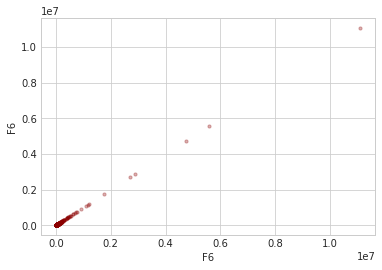

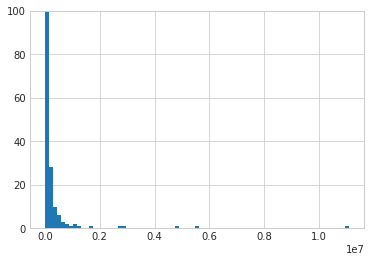

In [11]:
_ = sns.regplot(data.F6, data.F6, scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
plt.show()
_ = plt.hist(data['F6'], bins=75)
_ = plt.ylim([0, 100])
plt.show()

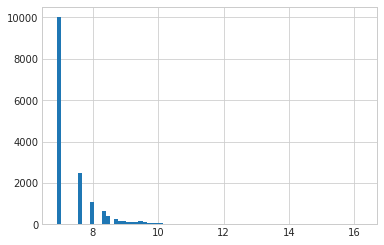

In [12]:
_ = plt.hist(np.log(data.F6), bins=75)

We can afford to lose 10 data points out of 14,000. Drop the ten huge outliers...

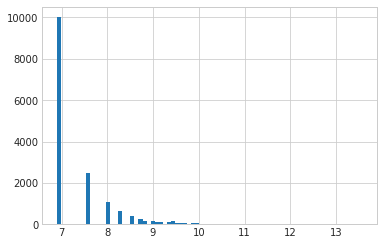

In [13]:
for i in range(10):
    data_point = data['F6'].idxmax()
    data.drop([data_point], inplace=True)
_ = plt.hist(np.log(data.F6), bins=75)

This feature looks more usable in this form. Lets keep it for now, but keep an eye on it.

In [14]:
data.F6 = np.log(data.F6)

In [15]:
#data_point = features['F6'].idxmax()
#while features.iloc[data_point]['F6'] > 0.6*10**7:
#    data_point = features['F6'].idxmax()
#    features.drop([data_point], inplace=True)
#    labels.drop([data_point], inplace=True)

#print(features.shape)
#print(labels.shape)

Now lets clean up `F16`

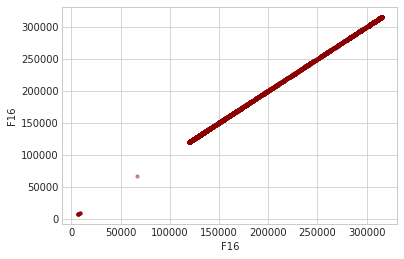

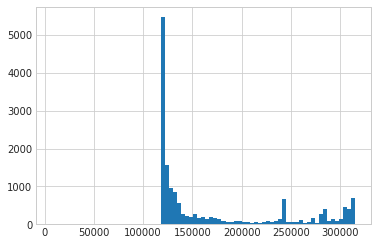

In [16]:
_ = sns.regplot(data.F16, data.F16, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
_ = plt.hist(data['F16'], bins=75)
plt.show()

Whatever this is, its clearly bounded by about 120,000 on the bottom and about 325,000 above. We can safely drop all values outside of that range.

In [17]:
print("Mode of F16 is: {}".format(data.F16.mode()))
bound = 119774
print("Counts of occurences of {} is: {}".format(bound,
                                                 data.F16[data.F16 == 119774].count()))

Mode of F16 is: 0    119777
dtype: int64
Counts of occurences of 119774 is: 0


In [18]:
data = data[data.F16 >= 119000]

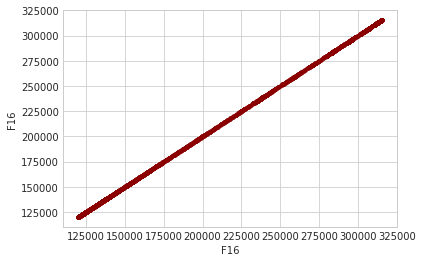

(16360, 26)

In [19]:
_ = sns.regplot(data.F16, data.F16, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
data.shape

Now we look at `F20`

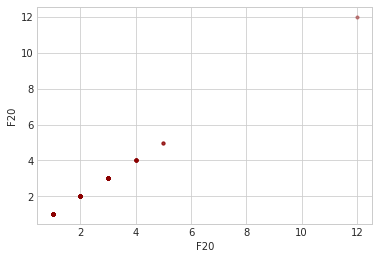

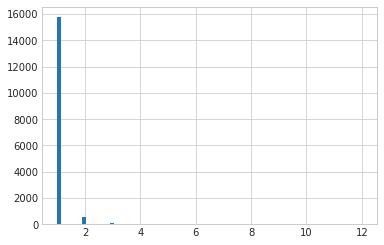

In [20]:
_ = sns.regplot(data.F20, data.F20, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
_ = plt.hist(data['F20'], bins=75)
plt.show()

Upon closer inspection, this data looks categorical, with almost all counts being in category 1. For simplicity, lets take those random $12$s and scoot them closer in.

In [21]:
for i in range(6,13):
    print("There are {} {}'s.".format(data.F20[data.F20 == i].count(), i))

There are 0 6's.
There are 0 7's.
There are 0 8's.
There are 0 9's.
There are 0 10's.
There are 0 11's.
There are 1 12's.


Since there is only one $12$, and almost all the other data points are $1$, let's just find that $12$ and drop it.

In [22]:
data = data[data.F20 != 12]

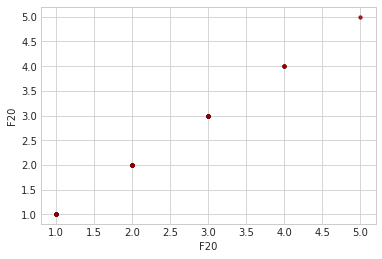

(16359, 26)

In [18]:
_ = sns.regplot(data.F20, data.F20, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
data.shape

At this point all the severe outliers are removed, and we can run a few preliminary models before moving on to some finer data inspection and feature engineering.

## Preliminary Modeling

In [48]:
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

### Simple Logistic Regression

10 fold CV, and average the accuracies. We will try with L1 penalty and L2 penalty.

In [20]:
accuracies = [] 
weights_L1 = []
for i in range(10):
    rand = np.random.randint(1, 100)
    X_train, X_test, y_train, y_test = train_test_split(features, labels)
    clf = LogisticRegression(penalty='l1', max_iter=1000, random_state=rand)
    _ = clf.fit(X_train, y_train)
    accuracies.append(clf.score(X_test, y_test))
    weights_L1.append(clf.coef_)

accuracies = np.array(accuracies)
print("Mean for L1 norm is: {}".format(np.mean(accuracies, axis=0)))
print("St Dev for L1 norm is: {}".format(np.std(accuracies, axis=0)))
print('')

accuracies = [] 
weights_L2 = []
for i in range(10):
    rand = np.random.randint(1, 100)
    X_train, X_test, y_train, y_test = train_test_split(features, labels)
    clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rand)
    _ = clf.fit(X_train, y_train)
    accuracies.append(clf.score(X_test, y_test))
    weights_L2.append(clf.coef_)
    
accuracies = np.array(accuracies)
print("Mean for L2 norm is: {}".format(np.mean(accuracies, axis=0)))
print("St Dev for L2 norm is: {}".format(np.std(accuracies, axis=0)))

Mean for L1 norm is: 0.9416136919315402
St Dev for L1 norm is: 0.0035763744749587375

Mean for L2 norm is: 0.9409290953545233
St Dev for L2 norm is: 0.0018172033424021575


Lets just average all these weights and use them.

In [21]:
#avgs = np.array([weights_L1, weights_L2])
#avgs = np.mean(np.mean(avgs, axis = 0), axis=2).reshape(10,)
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rand)
_ = clf.fit(features, labels)

In [24]:
test_data = pd.read_csv("test.csv")

In [34]:
test_data.F6 = np.log(test_data.F6)
test_features = test_data.drop(['id'], axis=1)
_ = clf.predict(test_features)
new_index = np.arange(16384,32769,1)

In [46]:
id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
y_hat = pd.DataFrame(_, columns=['Y'])
frames = [id_col, y_hat]
pred = pd.concat(frames, axis=1)

In [47]:
filename = 'prediction_logistic.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

Once I finally got the submission in correctly, this only gave a score of 0.50, not great.

### K-Nearest Neighbors

10 fold CV, and $n$ from 1 to 10 and average the accuracies.

In [56]:
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

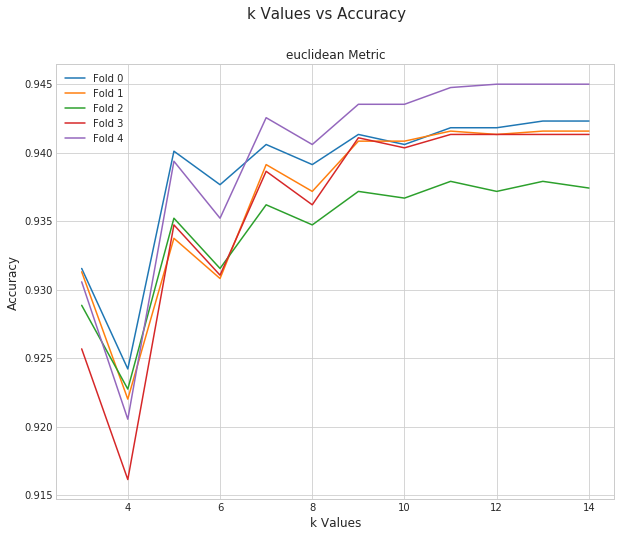

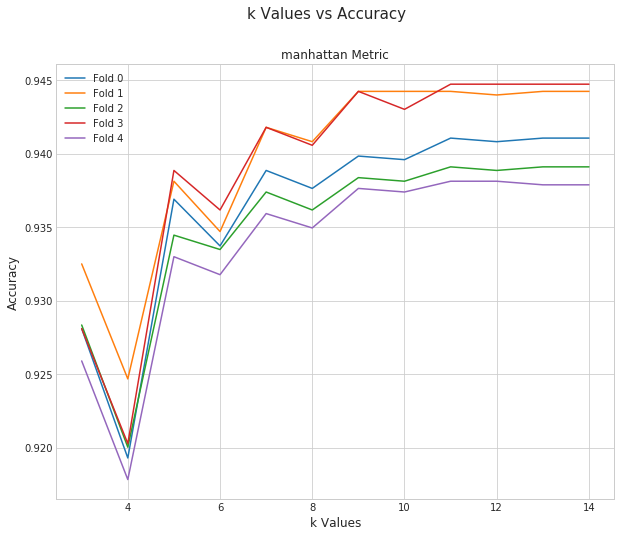

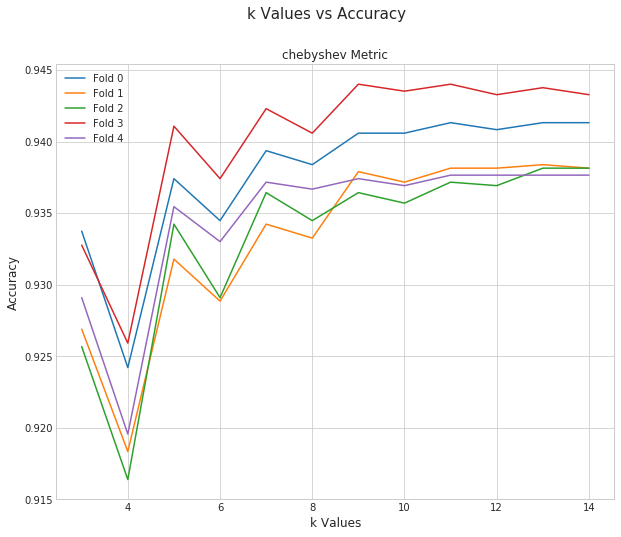

In [68]:
metrics = ['euclidean', 'manhattan', 'chebyshev']
folds = 5
k_vals = np.arange(3, 15, 1)
scores = np.empty((folds,len(k_vals)))

for metric in metrics:
    for i in range(folds):
        score = []
        X_train, X_test, y_train, y_test = train_test_split(features, labels)
        for k in k_vals:
            clf = KNeighborsClassifier(n_neighbors=k, metric=metric)
            _ = clf.fit(X_train, y_train)
            score.append(clf.score(X_test, y_test))
        scores[i, :] = score
    _ = plt.figure(figsize = (10,8))
    for i in range(folds):
        _ = plt.plot(k_vals, scores[i,:], label="Fold {}".format(i))

    _ = plt.xlabel("k Values", fontsize=12)
    _ = plt.ylabel("Accuracy", fontsize=12)
    _ = plt.suptitle("k Values vs Accuracy", fontsize=15)
    _ = plt.title("{} Metric".format(metric))
    _ = plt.legend()

### XGBoost

In [23]:
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)
y_train = y_train.reshape(12269,1)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [25]:
# specify parameters via map
param = {'max_depth':7, 'eta':0.7, 'gamma':0.8, 'silent':1, 'objective':'binary:logistic', 
         'early_stopping_rounds':5}
num_round = 200

bst = xgb.train(param, dtrain, num_round)
#pred = bst.predict(dtest)

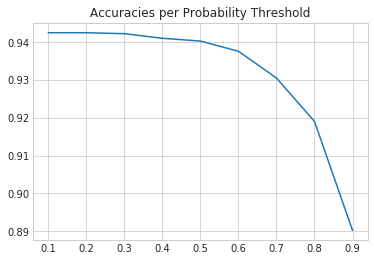

In [26]:
thresholds = np.arange(0.1, 1, 0.1)
scores = []
for alpha in thresholds:
    pred = bst.predict(dtest)
    for i in range(len(pred)):
        if pred[i] > alpha:
            pred[i] = 1 
        else:
            pred[i] = 0
    scores.append(accuracy_score(y_test, pred))

_ = plt.plot(thresholds, scores)
_ = plt.title('Accuracies per Probability Threshold')

In [27]:
scores

[0.9425427872860636,
 0.9425427872860636,
 0.9422982885085575,
 0.9410757946210269,
 0.9403422982885086,
 0.9376528117359413,
 0.930562347188264,
 0.9190709046454768,
 0.8902200488997555]

In [29]:
#test_data = pd.read_csv("test.csv")
#test_data.F6 = np.log(test_data.F6)
test_features = test_data.drop(['id'], axis=1)
dtest = xgb.DMatrix(test_features)
_ = bst.predict(dtest)
new_index = np.arange(16384,32769,1)
id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
y_hat = pd.DataFrame(_, columns=['Y'])
frames = [id_col, y_hat]
pred = pd.concat(frames, axis=1)
filename = 'prediction_xgb.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

In [ ]:
# Plotting the tree
#_ = xgb.plot_tree(bst)
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
#plt.show()

It looks like the base models are maxing out accuracy around $0.94$. ~~Time to do some more feature engineering and see if we can improve.~~<br>
For curiosity, I want to submit just a column of ones.

In [32]:
ones = np.ones((32769-16384, 1))
new_index = np.arange(16384,32769,1)
id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
y_hat = pd.DataFrame(ones, columns=['Y'])
frames = [id_col, y_hat]
pred = pd.concat(frames, axis=1)
filename = 'prediction_lazyones.csv'
pred.to_csv(filename, encoding='utf-8', index=False)